## Problem Definition — Salary Prediction

**Objective:**  
Predict an individual’s salary based on features like **experience, education, job title, gender, country, and race**.

**Problem Statement:**  
Build a **regression model** to estimate salaries accurately, helping organizations make informed compensation decisions and identify key factors affecting pay.

**Approach:**  
- Clean and preprocess data (handle missing values, encode categorical features, remove outliers)  
- Split into train/test sets  
- Train **single vs multiple feature Linear Regression** models  
- Evaluate with **RMSE** and **R²**  
- Save the best-performing model

**Expected Outcome:**  
A reliable model for salary prediction and insights into the main drivers of compensation.

##  Import Libraries

In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge

import joblib

##  Load Dataset

In [72]:
df= pd.read_csv("Salary_Data.csv")
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,UK,White
1,28.0,Female,Master's,Data Analyst,3.0,65000.0,USA,Hispanic
2,45.0,Male,PhD,Senior Manager,15.0,150000.0,Canada,White
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,USA,Hispanic
4,52.0,Male,Master's,Director,20.0,200000.0,USA,Asian


##  Dataset Overview

In [73]:
print("Shape:", df.shape)
df.info()

Shape: (6704, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
 6   Country              6704 non-null   object 
 7   Race                 6704 non-null   object 
dtypes: float64(3), object(5)
memory usage: 419.1+ KB


In [74]:
df.describe()

,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


In [75]:
df.dtypes

Age                    float64
Gender                  object
Education Level         object
Job Title               object
Years of Experience    float64
Salary                 float64
Country                 object
Race                    object
dtype: object

In [76]:
df.nunique()

Age                     41
Gender                   3
Education Level          7
Job Title              193
Years of Experience     37
Salary                 444
Country                  5
Race                    10
dtype: int64

In [77]:
df["Salary"].describe()

count      6699.000000
mean     115326.964771
std       52786.183911
min         350.000000
25%       70000.000000
50%      115000.000000
75%      160000.000000
max      250000.000000
Name: Salary, dtype: float64

##  Data Preprocessing

In [78]:
df.duplicated().sum()

np.int64(1535)

In [79]:
df = df.drop_duplicates()

In [80]:
df.shape

(5169, 8)

In [81]:
df.isnull().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
Country                0
Race                   0
dtype: int64

In [82]:
df.dropna(axis=0, inplace=True)

In [83]:
df.isnull().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
Country                0
Race                   0
dtype: int64

In [84]:
Q1 = df["Salary"].quantile(0.25)
Q3 = df["Salary"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_clean = df[(df["Salary"] >= lower) & (df["Salary"] <= upper)]

#### Due to the high cardinality of the Job Title feature (191 unique values), clustering similar roles into broader domains is necessary to reduce dimensionality and improve analytical clarity.

#### Grouping Job Titles

In [85]:
def categorize_job_title(job_title):
    job_title = str(job_title).lower() 
    if 'software' in job_title or 'developer' in job_title:
        return 'Software/Developer'
    elif 'data' in job_title or 'analyst' in job_title or 'scientist' in job_title:
        return 'Data Analyst/Scientist'
    elif 'manager' in job_title or 'director' in job_title or 'vp' in job_title:
        return 'Manager/Director/VP'
    elif 'sales' in job_title or 'representative' in job_title:
        return 'Sales'
    elif 'marketing' in job_title or 'social media' in job_title:
        return 'Marketing/Social Media'
    elif 'product' in job_title or 'designer' in job_title:
        return 'Product/Designer'
    elif 'hr' in job_title or 'human resources' in job_title:
        return 'HR/Human Resources'
    elif 'financial' in job_title or 'accountant' in job_title:
        return 'Financial/Accountant'
    elif 'project manager' in job_title:
        return 'Project Manager'
    elif 'it' in job_title or 'support' in job_title:
        return 'IT/Technical Support'
    elif 'operations' in job_title or 'supply chain' in job_title:
        return 'Operations/Supply Chain'
    elif 'customer service' in job_title or 'receptionist' in job_title:
        return 'Customer Service/Receptionist'
    else:
        return 'Other'

df['Job Title'] = df['Job Title'].apply(categorize_job_title)

In [86]:
# Count number of entries per Job Title
job_counts = df['Job Title'].value_counts().reset_index()
job_counts.columns = ['Job Title', 'Count']

# عرض النتائج
print(job_counts)

                        Job Title  Count
0              Software/Developer   1577
1             Manager/Director/VP   1354
2          Data Analyst/Scientist    929
3                           Other    554
4                           Sales    277
5              HR/Human Resources    172
6          Marketing/Social Media    158
7                Product/Designer     85
8   Customer Service/Receptionist     26
9            IT/Technical Support     15
10           Financial/Accountant     11
11        Operations/Supply Chain      5


In [87]:
top_jobs = job_counts['Job Title'].head(5).tolist()  # Top 5
df['Job Title'] = df['Job Title'].apply(lambda x: x if x in top_jobs else 'Other')

In [88]:
# Count number of entries per Job Title
job_counts = df['Job Title'].value_counts().reset_index()
job_counts.columns = ['Job Title', 'Count']

# عرض النتائج
print(job_counts)

                Job Title  Count
0      Software/Developer   1577
1     Manager/Director/VP   1354
2                   Other   1026
3  Data Analyst/Scientist    929
4                   Sales    277


#### The Education Level column includes inconsistent entries (e.g., "Bachelor" and "Bachelor degree") that refer to the same degree. These will be merged into one standardized category.

In [89]:
df['Education Level'].unique()

array(["Bachelor's", "Master's", 'PhD', "Bachelor's Degree",
       "Master's Degree", 'High School', 'phD'], dtype=object)

#### Grouping Education Level

In [90]:
def group_education(Educaton):
    
    Educaton = str(Educaton).lower()
    if 'high school' in Educaton:
        return 'High School'
    elif 'bachelor\'s' in Educaton:
        return 'Bachelors'
    elif 'master\'s' in Educaton:
        return 'Masters'
    elif 'phd' in Educaton:
        return 'PhD'

df['Education Level'] = df['Education Level'].apply(group_education) 

In [91]:
df['Education Level'].unique()

array(['Bachelors', 'Masters', 'PhD', 'High School'], dtype=object)

## Exploratory Data Analysis

### Job Title

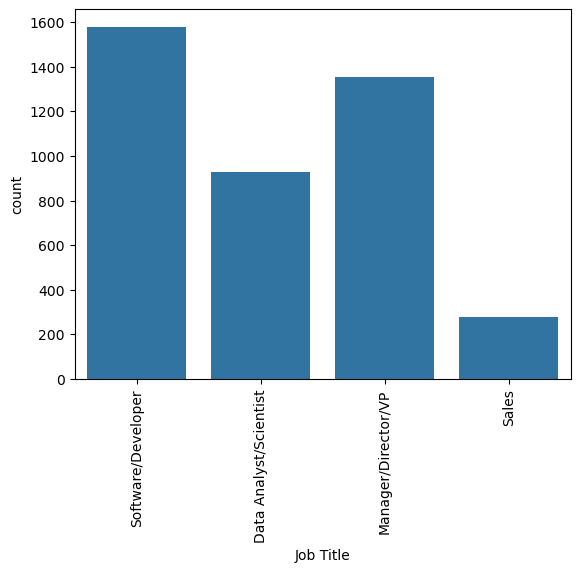

In [92]:
sns.countplot(x='Job Title', data=df[df['Job Title'] != 'Other'])
plt.xticks(rotation=90)
plt.show()

### Education Level

C:\Users\moham\AppData\Local\Temp\ipykernel_22076\1722440352.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'Education Level', data = df, palette='Set1')


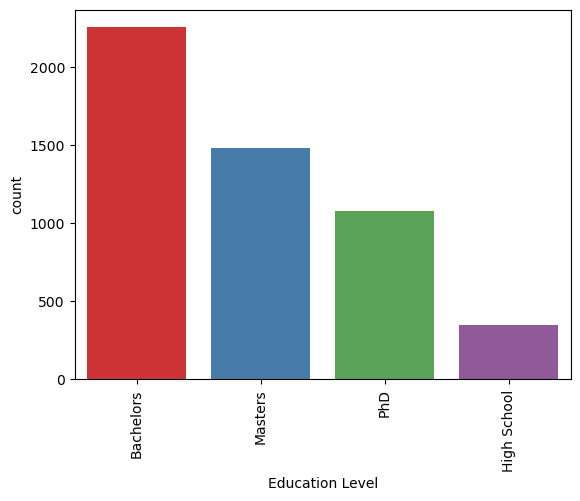

In [93]:
sns.countplot(x = 'Education Level', data = df, palette='Set1')
plt.xticks(rotation=90)
plt.show()

### Age Distribution

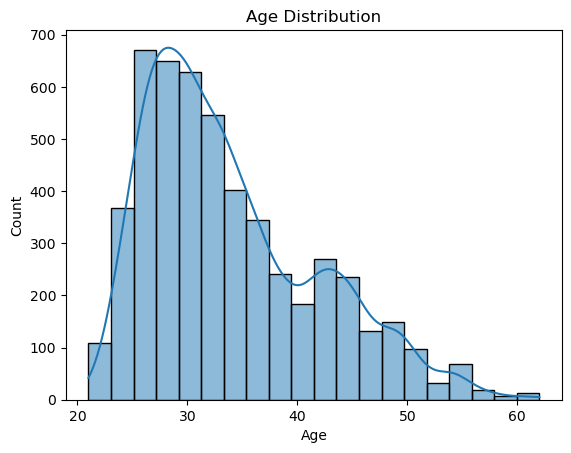

In [94]:
sns.histplot(data=df, x='Age', bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

#### Years of Experience

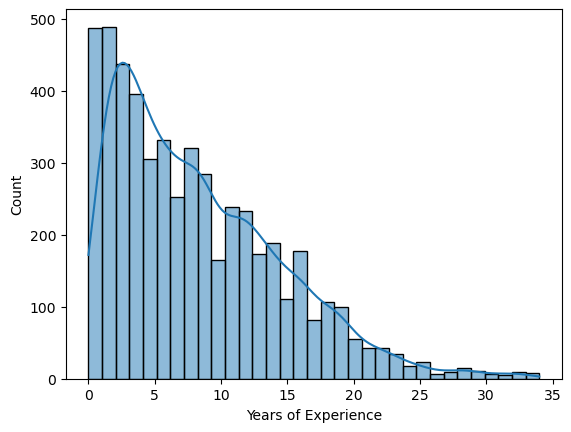

In [95]:
sns.histplot(x = 'Years of Experience', data = df,kde=True)
plt.show()

### Pie chart for Gender

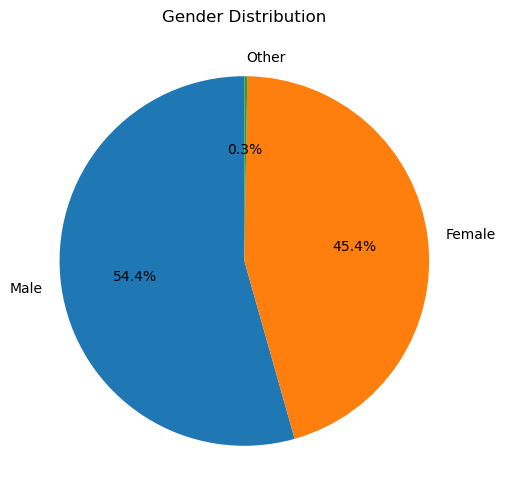

In [96]:
plt.figure(figsize=(10,6))
plt.pie(df['Gender'].value_counts(), labels=['Male','Female', 'Other'], autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.show()

#### Job Title and Salary

C:\Users\moham\AppData\Local\Temp\ipykernel_22076\3276374967.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Job Title', y = 'Salary', data = df, palette = 'Set2')


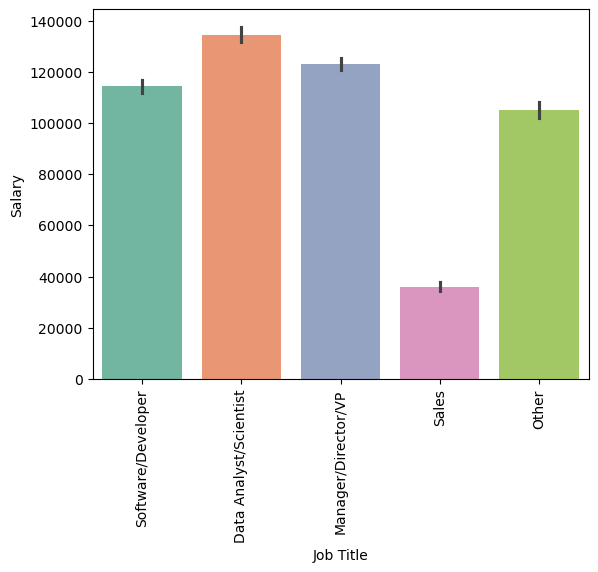

In [97]:
sns.barplot(x = 'Job Title', y = 'Salary', data = df, palette = 'Set2')
plt.xticks(rotation = 90)
plt.show()

#### Age and Salary

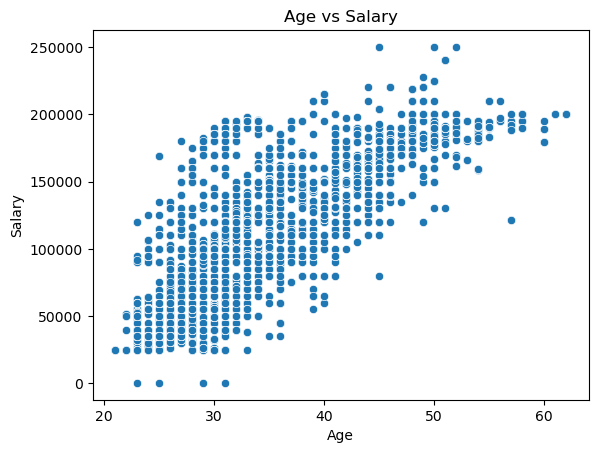

In [98]:
sns.scatterplot(x = 'Age', y='Salary', data=df)
plt.title('Age vs Salary')
plt.show()

#### Experience and Salary

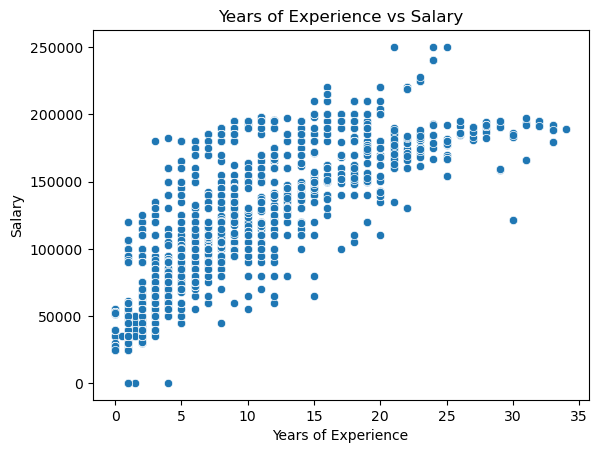

In [99]:
sns.scatterplot(x= 'Years of Experience', y  = 'Salary', data = df).set_title('Years of Experience vs Salary')
plt.show()

##   Model Development

### multiple feature model

In [100]:
df_clean["Salary"] = np.log1p(df_clean["Salary"])

In [101]:
X = df_clean.drop("Salary", axis=1)
y = df_clean["Salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

In [103]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [105]:
y_pred_log = lin_model.predict(X_test_scaled)

y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)



print("Ridge Regression RMSE:", rmse)
print("Ridge Regression R²:", r2)

Ridge Regression RMSE: 26158.9704414691
Ridge Regression R²: 0.7465644809103744


### single feature model

In [106]:
X_single = df[['Years of Experience']]
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_single, y, test_size=0.2, random_state=42
)

# Standardize
X_train_s_scaled = scaler.fit_transform(X_train_s)
X_test_s_scaled = scaler.transform(X_test_s)

# Train
lin_single = LinearRegression()
lin_single.fit(X_train_s_scaled, y_train_s)

# Evaluate
y_pred_s = lin_single.predict(X_test_s_scaled)
rmse_s = np.sqrt(mean_squared_error(y_test_s, y_pred_s))
r2_s = r2_score(y_test_s, y_pred_s)

print("Single Feature Linear Regression RMSE:", rmse_s)
print("Single Feature Linear Regression R²:", r2_s)

Single Feature Linear Regression RMSE: 0.36199428031011627
Single Feature Linear Regression R²: 0.5532542330753136


### save best model

In [107]:
joblib.dump(lin_model, "best_salary_linear_model.pkl")
joblib.dump(scaler, "salary_scaler.pkl")

['salary_scaler.pkl']